### Project name: FleetPhase-Out
### Author : David Zireva

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r'C:\Users\NHOPI\Downloads\defleet_truck_dataset.csv')

In [4]:
df = df.drop(columns = ['Vehicle_ID','Usage_Type'], axis = 1 )
df

,Make,Age_Years,Outlook_Score,Mileage_km,Maintenance_Costs,Fuel_Efficiency_kmpl,Accident_History,Defleet
0,Volvo,9,2,350000.000000,19000.000000,2.347789,5,1
1,MAN,6,7,350500.417014,19045.871560,2.067445,9,0
2,MAN,8,9,351000.834028,19091.743119,2.340909,7,0
3,Freightliner,7,4,351501.251043,19137.614679,2.407125,3,1
4,Freightliner,8,2,352001.668057,19183.486239,1.335627,9,0
...,...,...,...,...,...,...,...,...
1195,Mercedes Actros,8,10,947998.331943,73816.513761,1.448195,0,0
1196,Freightliner,8,1,948498.748957,73862.385321,1.771937,3,0
1197,Mercedes Actros,6,6,948999.165972,73908.256881,2.008807,9,0
1198,Volvo,10,4,949499.582986,73954.128440,1.885824,1,1


### EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  1200 non-null   object 
 1   Age_Years             1200 non-null   int64  
 2   Outlook_Score         1200 non-null   int64  
 3   Mileage_km            1200 non-null   float64
 4   Maintenance_Costs     1200 non-null   float64
 5   Fuel_Efficiency_kmpl  1200 non-null   float64
 6   Accident_History      1200 non-null   int64  
 7   Defleet               1200 non-null   int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 75.1+ KB


In [7]:
cat_col = df.columns
for i in cat_col:
    print(df[i].value_counts(),'\n'*2,'*'*50,'\n')

Make
Volvo              325
Freightliner       260
MAN                252
Mercedes Actros    206
Scania             157
Name: count, dtype: int64 

 ************************************************** 

Age_Years
7     215
6     206
8     186
9     164
5     147
10    117
11    105
12     60
Name: count, dtype: int64 

 ************************************************** 

Outlook_Score
1     136
7     130
3     128
9     124
10    123
2     119
4     116
8     110
5     108
6     106
Name: count, dtype: int64 

 ************************************************** 

Mileage_km
350000.000000    1
753336.113428    1
752335.279399    1
751834.862385    1
751334.445371    1
                ..
549666.388657    1
549165.971643    1
548665.554629    1
548165.137615    1
950000.000000    1
Name: count, Length: 1200, dtype: int64 

 ************************************************** 

Maintenance_Costs
19000.000000    1
55972.477064    1
55880.733945    1
55834.862385    1
55788.990826    1
      

#### Feature Distribution

array([[<Axes: title={'center': 'Age_Years'}>,
        <Axes: title={'center': 'Outlook_Score'}>,
        <Axes: title={'center': 'Mileage_km'}>],
       [<Axes: title={'center': 'Maintenance_Costs'}>,
        <Axes: title={'center': 'Fuel_Efficiency_kmpl'}>,
        <Axes: title={'center': 'Accident_History'}>],
       [<Axes: title={'center': 'Defleet'}>, <Axes: >, <Axes: >]],
      dtype=object)

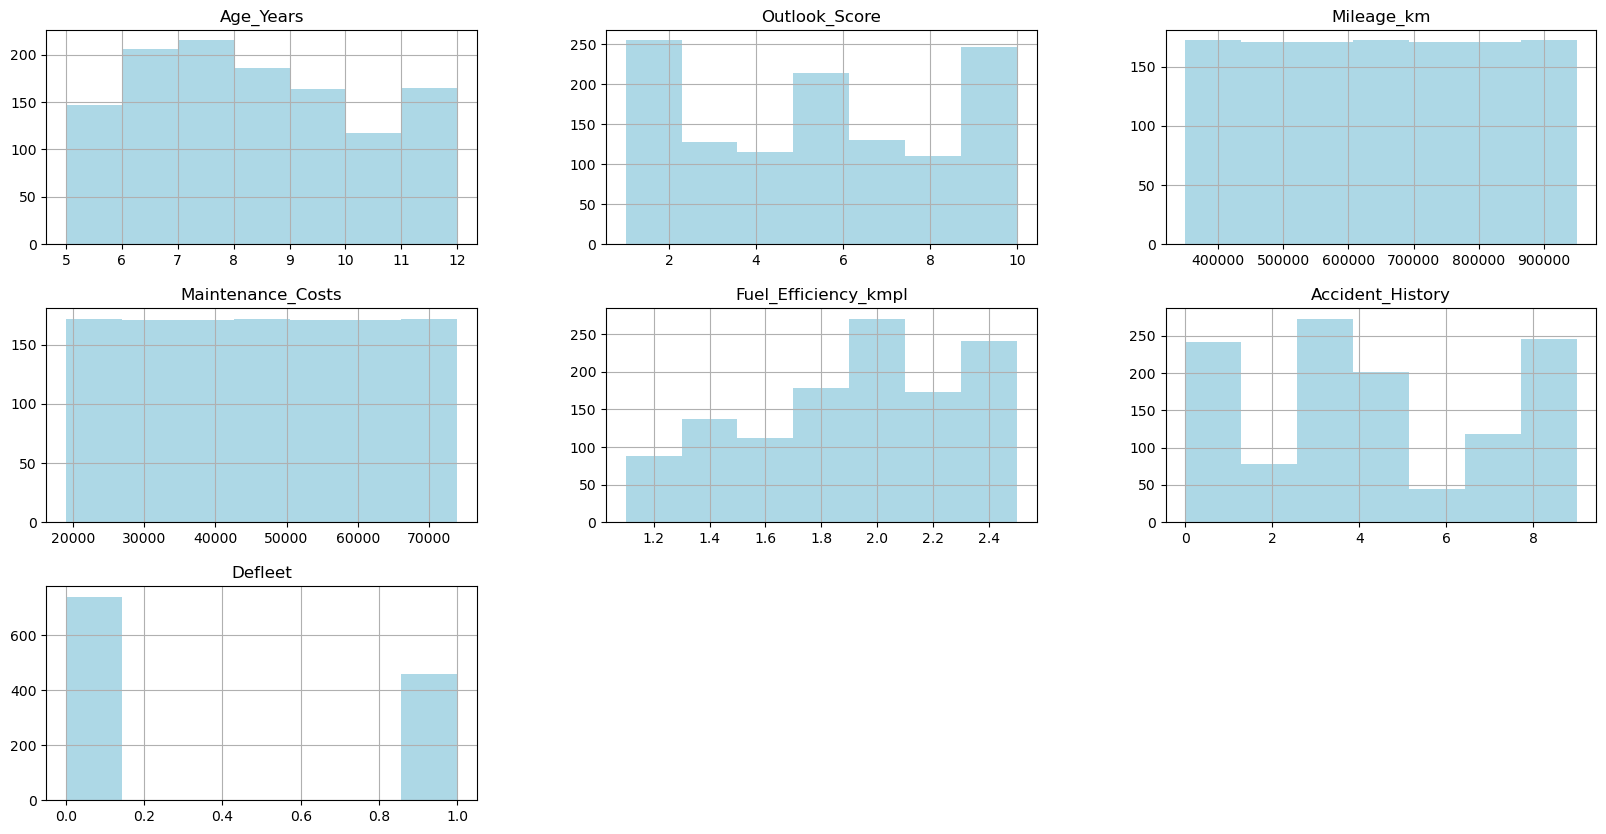

In [9]:
df.hist(figsize=(20,10),bins=7, color='lightblue')

Looking at the histograms above I can make some quick inferences:

* The majority of the trucks fall within the 3 to 9-year age group.
* The truck outlook scores are spread across the extremes, with an equal proportion of trucks in both good and bad condition.
* The majority of the trucks have a fuel consumption rate of 2.0.
* Many trucks have been involved in at least one accident.

#### Define Categorical and Numerical Features

In [12]:
columns = list(df.columns)

categoric_columns = []
numeric_columns = []

for i in columns:
    if len(df[i].unique()) != 5:
        numeric_columns.append(i)
    else:
        categoric_columns.append(i)
        
# Assuming the first column is an ID or non-numeric feature
numeric_columns = numeric_columns[1:]

print('Numerical features: ', numeric_columns)
print('Categorical features: ', categoric_columns)


Numerical features:  ['Outlook_Score', 'Mileage_km', 'Maintenance_Costs', 'Fuel_Efficiency_kmpl', 'Accident_History', 'Defleet']
Categorical features:  ['Make']


####  Encode Categorical Features and Scale Numerical Features

In [14]:
encoder = OneHotEncoder(sparse_output= False, handle_unknown= 'ignore').set_output(transform= 'pandas')
X1 = encoder.fit_transform(df[categoric_columns])

In [15]:
X1

,Make_Freightliner,Make_MAN,Make_Mercedes Actros,Make_Scania,Make_Volvo
0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1195,0.0,0.0,1.0,0.0,0.0
1196,1.0,0.0,0.0,0.0,0.0
1197,0.0,0.0,1.0,0.0,0.0
1198,0.0,0.0,0.0,0.0,1.0


In [16]:
df = pd.concat(objs = [df, X1], axis = 1).drop(columns = ['Make'], axis = 1)
df

,Age_Years,Outlook_Score,Mileage_km,Maintenance_Costs,Fuel_Efficiency_kmpl,Accident_History,Defleet,Make_Freightliner,Make_MAN,Make_Mercedes Actros,Make_Scania,Make_Volvo
0,9,2,350000.000000,19000.000000,2.347789,5,1,0.0,0.0,0.0,0.0,1.0
1,6,7,350500.417014,19045.871560,2.067445,9,0,0.0,1.0,0.0,0.0,0.0
2,8,9,351000.834028,19091.743119,2.340909,7,0,0.0,1.0,0.0,0.0,0.0
3,7,4,351501.251043,19137.614679,2.407125,3,1,1.0,0.0,0.0,0.0,0.0
4,8,2,352001.668057,19183.486239,1.335627,9,0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,8,10,947998.331943,73816.513761,1.448195,0,0,0.0,0.0,1.0,0.0,0.0
1196,8,1,948498.748957,73862.385321,1.771937,3,0,1.0,0.0,0.0,0.0,0.0
1197,6,6,948999.165972,73908.256881,2.008807,9,0,0.0,0.0,1.0,0.0,0.0
1198,10,4,949499.582986,73954.128440,1.885824,1,1,0.0,0.0,0.0,0.0,1.0


In [17]:
num_cols = df[numeric_columns].drop('Defleet',axis = 1).columns
num_cols
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [18]:
df

,Age_Years,Outlook_Score,Mileage_km,Maintenance_Costs,Fuel_Efficiency_kmpl,Accident_History,Defleet,Make_Freightliner,Make_MAN,Make_Mercedes Actros,Make_Scania,Make_Volvo
0,9,0.111111,0.000000,0.000000,0.891278,0.555556,1,0.0,0.0,0.0,0.0,1.0
1,6,0.666667,0.000834,0.000834,0.691032,1.000000,0,0.0,1.0,0.0,0.0,0.0
2,8,0.888889,0.001668,0.001668,0.886364,0.777778,0,0.0,1.0,0.0,0.0,0.0
3,7,0.333333,0.002502,0.002502,0.933661,0.333333,1,1.0,0.0,0.0,0.0,0.0
4,8,0.111111,0.003336,0.003336,0.168305,1.000000,0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,8,1.000000,0.996664,0.996664,0.248711,0.000000,0,0.0,0.0,1.0,0.0,0.0
1196,8,0.000000,0.997498,0.997498,0.479955,0.333333,0,1.0,0.0,0.0,0.0,0.0
1197,6,0.555556,0.998332,0.998332,0.649148,1.000000,0,0.0,0.0,1.0,0.0,0.0
1198,10,0.333333,0.999166,0.999166,0.561303,0.111111,1,0.0,0.0,0.0,0.0,1.0


#### Correlation Among Features¶

Before I move onto splitting the dataset and assessing feature importance, I want to look closely at the correlation among features in this dataset.

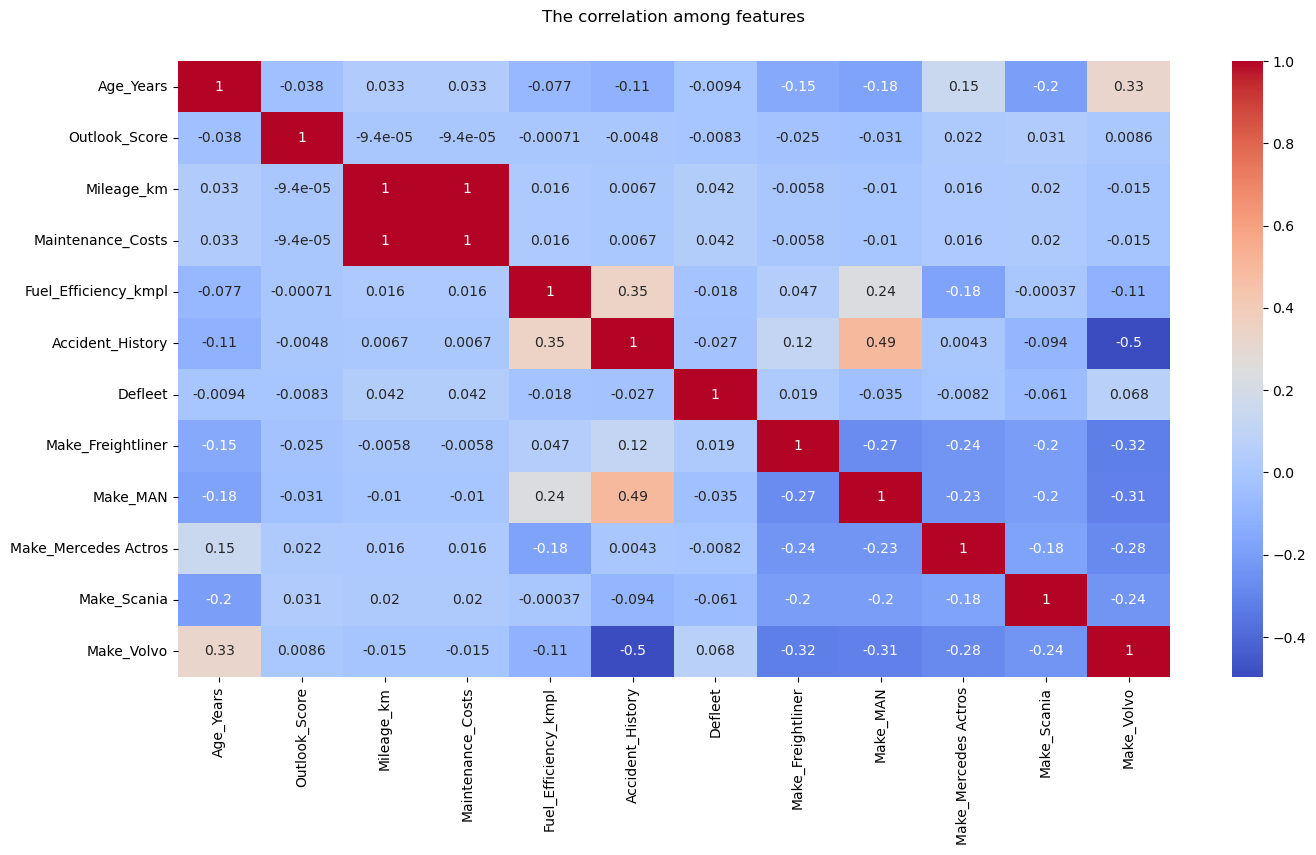

In [21]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), annot = True, cmap = "coolwarm")
plt.title('The correlation among features',y= 1.05)
plt.show()

In [22]:
X = df.drop(columns = ['Defleet'], axis = 1)
y = df['Defleet']

#### Splitting the dataset into train and test sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Feature Importance¶

I always find this step really worthwhile, we can use a classification model to determine the importance of features in our dataset in terms of predicting our target variable. In this case, I'm using a RandomForestClassifier to assess the relative importance of features to predicting y.

In [27]:
clf = RandomForestClassifier(random_state = 42)
clf = clf.fit(X, y)
fimp = pd.Series(data=clf.feature_importances_, index=X.columns).sort_values(ascending=False)

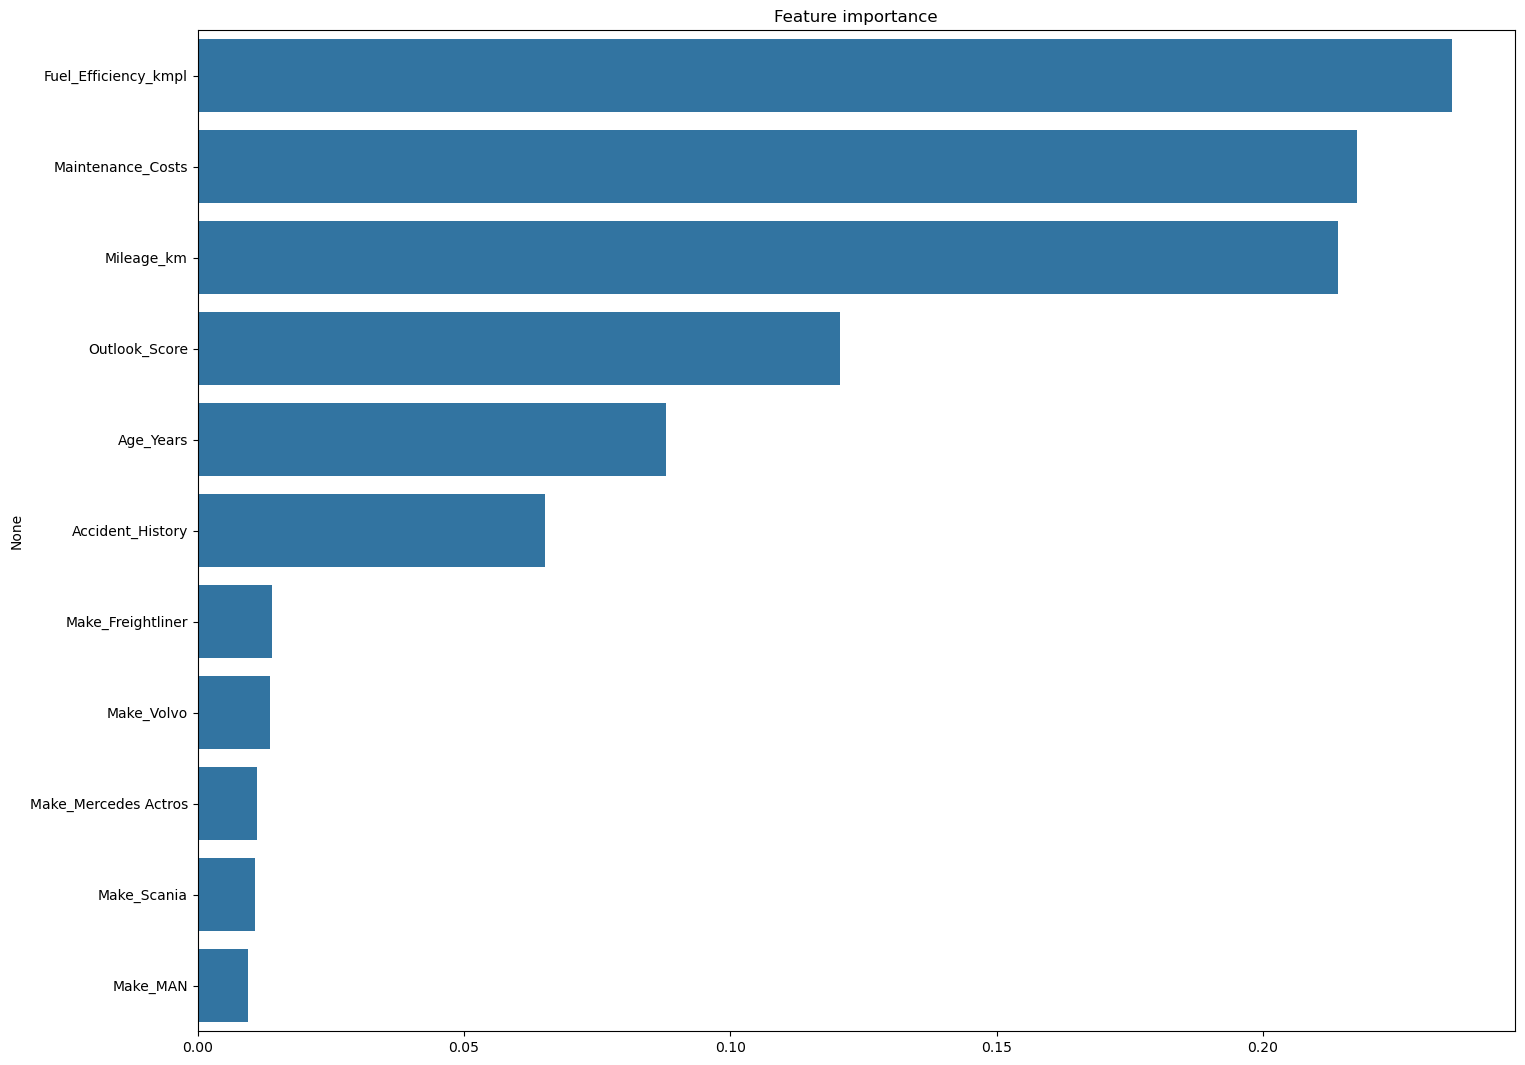

In [28]:
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, orient='h')

#### Selecting a Classification Model

I create a dictionary containing various classification models, along with two empty lists: model_names and accuracies. Using a for loop, I iterate through the dictionary to fit each model to the training data. After fitting, I use the model to predict the test data (y_test) and evaluate its performance with the clf.score function. The model names and their corresponding accuracy scores are appended to the model_names and accuracies lists, respectively. Finally, I compile this information into a DataFrame and use a bar plot to visualize the performance of the models, highlighting the most accurate ones.

In [31]:
#--- Dictionary of classification models
classification_models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gaussian Naive Bayes": GaussianNB()
   }

model_names = []
accuracies = []

In [32]:
#---- Train and evaluate each model
for name, clf in classification_models.items():
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    model_names.append(name)
    accuracies.append(score)
    print(f"{name} accuracy: {score:.2f}")

Logistic Regression accuracy: 0.62
K-Nearest Neighbors accuracy: 0.55
Support Vector Machine accuracy: 0.62
Decision Tree accuracy: 0.56
Random Forest accuracy: 0.65
Gradient Boosting accuracy: 0.62
AdaBoost accuracy: 0.60
Gaussian Naive Bayes accuracy: 0.63


In [33]:
#--- Create a DataFrame for model accuracies
df_models = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies}).sort_values()
df_models

,Model,Accuracy
0,Logistic Regression,0.620833
1,K-Nearest Neighbors,0.554167
2,Support Vector Machine,0.616667
3,Decision Tree,0.558333
4,Random Forest,0.650000
5,Gradient Boosting,0.620833
6,AdaBoost,0.600000
7,Gaussian Naive Bayes,0.629167


#### Model accuracies Plot 

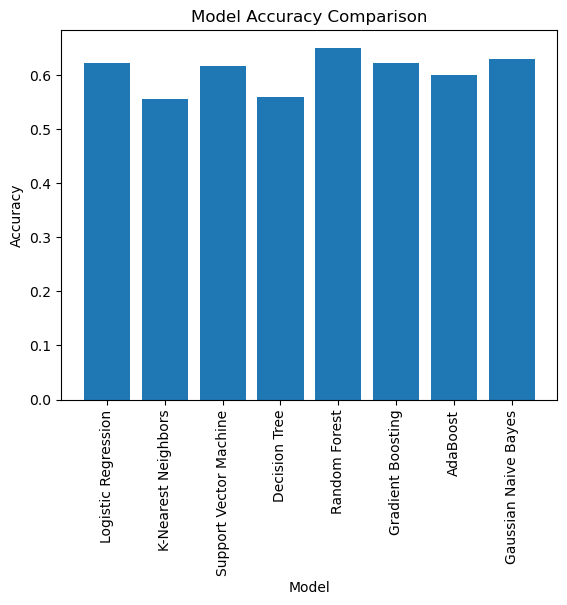

In [110]:
plt.bar(x=list(df_models['Model']), height=list(df_models['Accuracy']))
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=90) 
plt.show()

We can see that there are multiple models that would be effective for this task:

* Logistic Regression ,
* Support Vector Machine ,
* Random Forest ,
* Gradient Boosting ,
* XGBoost ,
* Gaussian Naive Bayes

#### Find the best model

In [137]:
accuracies.index(max(accuracies))

4

In [118]:
best_index = accuracies.index(max(accuracies))
best_model_name = model_names[best_index]
best_model = classification_models[best_model_name]

print(f"The best model is: {best_model_name} with an accuracy of {accuracies[best_index]:.2f}")

The best model is: Random Forest with an accuracy of 0.65


#### Model Evaluation

I fit the best model to the training data and use it to make predictions on y_test. The results are summarized in a confusion matrix, providing a quick evaluation of the model's performance. The accuracy of the model is approximately 65%, but the matrix reveals a significant number of misclassified predictions.

In [122]:
#---- Initialize and train model
best_model.fit(X_train, y_train)
model_score = best_model.score(X_test, y_test)
y_pred = best_model.predict(X_test)

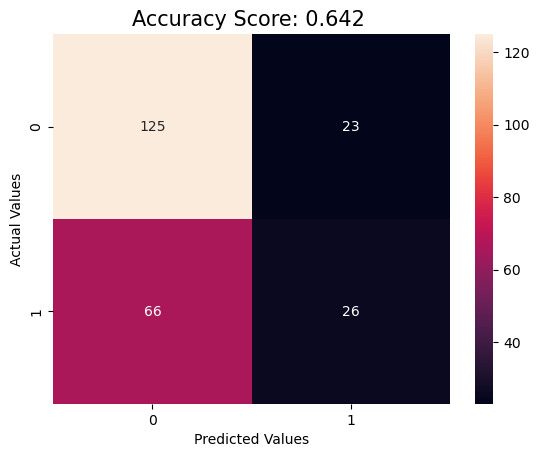

In [123]:
#----- Calculate and plot the confusion matrix
score = round(accuracy_score(y_test, y_pred), 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: 0.642 '.format(score), size=15)
plt.show()

#### Hyperparameter tuning

In [125]:
param = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

model = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator= model,
    param_distributions= param,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}


In [126]:
rfc = RandomForestClassifier(n_estimators = 300, min_samples_split = 5, min_samples_leaf = 4, max_features = 'log2',
                              max_depth= 20, bootstrap= True)

In [127]:
model = rfc.fit(X_train, y_train)

In [129]:
score = model.score(X_test, y_test)
score

0.6333333333333333

#### Model Evaluation (again)

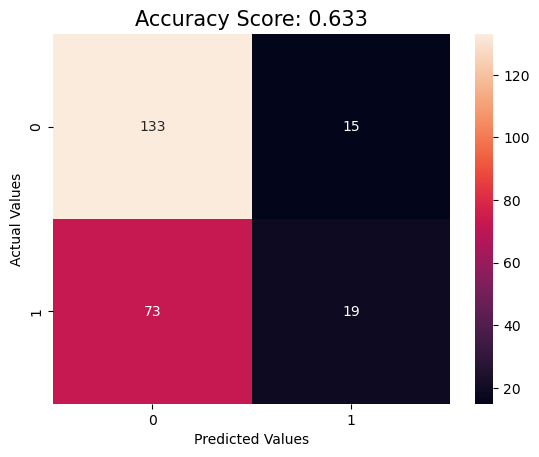

In [135]:
y_pred = model.predict(X_test)

#---- Calculate and plot the confusion matrix
score = round(accuracy_score(y_test, y_pred), 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size=15)
plt.show()

#### Reducing Dimensionality

We know from our earlier investigation that the most important features are Fuel_Efficiency_kmpl, Maintenance_Costs and Mileage_km. We use these as feature variables on the model.

In [ ]:
fimp.head(3)

What happens to our predictions if we only use these as predictors?

In [ ]:
X_train = X_train[['Fuel_Efficiency_kmpl', 'Maintenance_Costs', 'Mileage_km']]
X_test = X_test[['Fuel_Efficiency_kmpl', 'Maintenance_Costs', 'Mileage_km']]

In [ ]:
classification_models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gaussian Naive Bayes": GaussianNB()
   }

model_names = []
accuracies = []

In [ ]:
#-  Train and evaluate each model
for name, clf in classification_models.items():
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    model_names.append(name)
    accuracies.append(score)
    print(f"{name} accuracy: {score:.2f}")

This is quite fascinating. While the model's accuracy decreases slightly, the dimensionality is significantly reduced. Remarkably, we can predict students' academic success with approximately 62% accuracy using only three features.